In [1]:
import os
import sys
sys.path.append(os.path.join(os.getcwd().replace("distilled_models", "")))

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from parse_dataset import NetworkDataset, parse_dataset, split_datasets
from model import Model
from knowledge_distillation import KnowledgeDistillation

In [2]:
conf = {
    "batch_size": 516,
    "epochs": 15,
    "learning_rate": 0.0001
}

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [4]:
# extract dataset from csv file
network_data_file = os.path.join(os.getcwd().replace("distilled_models", ""), "datasets", "network_packet_data_test.csv")
data, labels, label_dict = parse_dataset(network_data_file)

# split dataset into train, val and test datasets
X_train, y_train, X_val, y_val, X_test, y_test = split_datasets(data, labels)
print(X_train.shape)
print(y_train.shape)

# create train, val and test dataloaders
train_dataset = NetworkDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=conf["batch_size"], shuffle=True)

val_dataset = NetworkDataset(X_val, y_val)
val_loader = DataLoader(val_dataset, batch_size=conf["batch_size"], shuffle=True)

test_dataset = NetworkDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=conf["batch_size"])

packet_dat,attack_cat

torch.Size([356334, 513])
torch.Size([356334])


In [5]:
# create MLP model:
class MLP(nn.Module):
    def __init__(self, size):
        super(MLP, self).__init__()
        self.mlp = nn.Sequential(
            nn.Linear(size, 320),
            nn.BatchNorm1d(320),
            nn.ReLU(),
            nn.Dropout(p=0.10),

            nn.Linear(320, 24)
        )
    
    def forward(self, x):
        out = self.mlp(x)
        return out

In [6]:
# create light MLP model
class LightMLP(nn.Module):
    def __init__(self, size):
        super(LightMLP, self).__init__()
        self.mlp = nn.Sequential(
            nn.Linear(size, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Dropout(p=0.10),

            nn.Linear(32, 24)
        )
    
    def forward(self, x):
        out = self.mlp(x)
        return out

In [7]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=2.1, alpha=0.9, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        self.reduction = reduction

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss

        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

In [8]:
# Load teacher model
teacher_model = MLP(X_train.shape[1]).to(device)
teacher_criterion = FocalLoss()
teacher_optimizer = torch.optim.AdamW(teacher_model.parameters(), lr=conf["learning_rate"], weight_decay=0.01)
teacher_scheduler = torch.optim.lr_scheduler.ExponentialLR(teacher_optimizer, 0.9)

teacher = Model(teacher_model, teacher_criterion, teacher_optimizer, teacher_scheduler, device)

checkpoint_path = os.path.join(os.getcwd().replace("distilled_models", ""), "checkpoint", "mlp_model.pth")
teacher.load(checkpoint_path)

Checkpoint loaded from /home/jorgetf/testmodel/Network-Packet-ML-Model/checkpoint/mlp_model.pth!


In [9]:
# create light model
torch.manual_seed(42)
student_model = LightMLP(X_train.shape[1]).to(device)
student_criterion = FocalLoss()
student_optimizer = torch.optim.AdamW(student_model.parameters(), lr=conf["learning_rate"], weight_decay=0.01)
student_scheduler = torch.optim.lr_scheduler.ExponentialLR(student_optimizer, 0.9)

student = Model(student_model, student_criterion, student_optimizer, student_scheduler, device)

In [10]:
def plot_data(data, type, title, n_epochs=conf["epochs"]):
    epochs = [epoch for epoch in range(1, n_epochs + 1)]
    data = [d.to('cpu') for d in data]
    plt.plot(epochs, data, marker="+", linestyle="dotted")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel(type)
    plt.show()

Epoch: 1/15, Accuracy: 41.70%, Train loss: 2.1362, Val loss: 1.9111
Epoch: 2/15, Accuracy: 55.12%, Train loss: 1.3432, Val loss: 1.5454
Epoch: 3/15, Accuracy: 54.41%, Train loss: 1.0327, Val loss: 1.4336
Epoch: 4/15, Accuracy: 67.35%, Train loss: 0.8839, Val loss: 0.9271
Epoch: 5/15, Accuracy: 67.52%, Train loss: 0.7832, Val loss: 0.9014
Epoch: 6/15, Accuracy: 69.37%, Train loss: 0.7164, Val loss: 0.7707
Epoch: 7/15, Accuracy: 70.90%, Train loss: 0.6605, Val loss: 0.7396
Epoch: 8/15, Accuracy: 68.98%, Train loss: 0.6290, Val loss: 0.6995
Epoch: 9/15, Accuracy: 73.60%, Train loss: 0.5874, Val loss: 0.5494
Epoch: 10/15, Accuracy: 71.58%, Train loss: 0.5581, Val loss: 0.6813
Epoch: 11/15, Accuracy: 70.40%, Train loss: 0.5335, Val loss: 0.6848
Epoch: 12/15, Accuracy: 74.49%, Train loss: 0.5231, Val loss: 0.5505
Epoch: 13/15, Accuracy: 76.26%, Train loss: 0.5008, Val loss: 0.4486
Epoch: 14/15, Accuracy: 76.72%, Train loss: 0.4787, Val loss: 0.4339
Epoch: 15/15, Accuracy: 75.27%, Train loss:

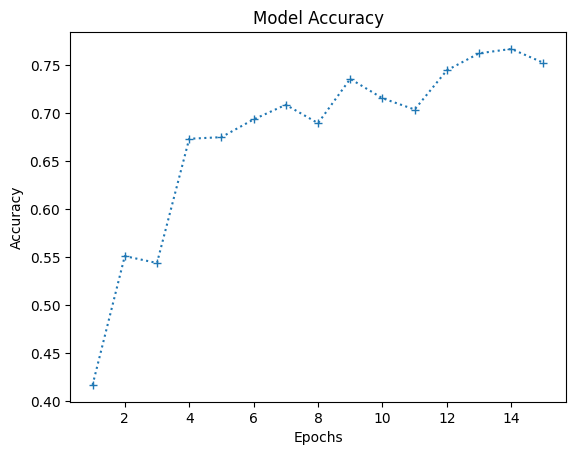

In [11]:
accuracy, train_loss, val_loss = student.train(train_loader=train_loader, val_loader=val_loader, epochs=conf["epochs"])
plot_data(accuracy, type="Accuracy", title="Model Accuracy")

In [12]:
test_loss, test_acc = student.evaluate(test_loader)
print(f"Accuracy: {100*test_acc:.2f}%, Test loss: {test_loss:.4f}")

Accuracy: 75.25%, Test loss: 0.4619


In [13]:
# create new light model
torch.manual_seed(42)
new_student_model = LightMLP(X_train.shape[1]).to(device)
new_student_criterion = FocalLoss()
new_student_optimizer = torch.optim.AdamW(new_student_model.parameters(), lr=conf["learning_rate"], weight_decay=0.01)
new_student_scheduler = torch.optim.lr_scheduler.ExponentialLR(new_student_optimizer, 0.9)

new_student = Model(new_student_model, new_student_criterion, new_student_optimizer, new_student_scheduler, device)

In [14]:
kd = KnowledgeDistillation(teacher=teacher, student=new_student, device=device)

Epoch: 1/15, Accuracy: 48.55%, Train loss: 0.0032, Val loss: 1.8438
Epoch: 2/15, Accuracy: 63.85%, Train loss: 0.0018, Val loss: 1.2034
Epoch: 3/15, Accuracy: 64.25%, Train loss: 0.0014, Val loss: 1.1920
Epoch: 4/15, Accuracy: 70.26%, Train loss: 0.0012, Val loss: 0.7225
Epoch: 5/15, Accuracy: 71.97%, Train loss: 0.0010, Val loss: 0.6686
Epoch: 6/15, Accuracy: 71.69%, Train loss: 0.0009, Val loss: 0.6078
Epoch: 7/15, Accuracy: 71.21%, Train loss: 0.0009, Val loss: 0.6506
Epoch: 8/15, Accuracy: 71.89%, Train loss: 0.0008, Val loss: 0.6044
Epoch: 9/15, Accuracy: 77.01%, Train loss: 0.0008, Val loss: 0.4525
Epoch: 10/15, Accuracy: 73.85%, Train loss: 0.0007, Val loss: 0.5558
Epoch: 11/15, Accuracy: 76.32%, Train loss: 0.0007, Val loss: 0.4555
Epoch: 12/15, Accuracy: 78.14%, Train loss: 0.0007, Val loss: 0.4038
Epoch: 13/15, Accuracy: 79.36%, Train loss: 0.0007, Val loss: 0.3640
Epoch: 14/15, Accuracy: 78.72%, Train loss: 0.0006, Val loss: 0.3847
Epoch: 15/15, Accuracy: 77.80%, Train loss:

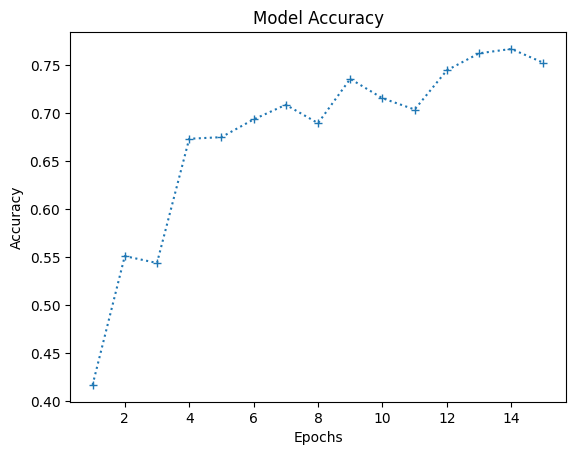

In [15]:
new_accuracy, new_train_loss, new_val_loss = kd.train_kd(train_loader, val_loader, conf["epochs"])
plot_data(accuracy, type="Accuracy", title="Model Accuracy")


In [17]:
new_test_loss, new_test_acc = new_student.evaluate(test_loader)
print(f"Accuracy: {100*new_test_acc:.2f}%, Test loss: {new_test_loss:.4f}")

Accuracy: 77.63%, Test loss: 0.4139


In [16]:
new_checkpoint_path = os.path.join(os.getcwd().replace("distilled_models", ""), "checkpoint", "light_mlp_model.pth")
new_student.save(new_checkpoint_path)

Checkpoint saved at /home/jorgetf/testmodel/Network-Packet-ML-Model/checkpoint/light_mlp_model.pth
